In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import datetime as dt
from pandas.tseries.offsets import DateOffset
import seaborn as sns
from pandas.tseries.offsets import MonthEnd

from scipy.stats import ttest_ind

## Preprocessing of data from stock analysis

#### Load stock_data

In [39]:
stock_data=pd.read_csv('./data/AAPL_2015_to_2020_yahoo_finance.csv')
apple_event_and_stock_data=pd.read_csv('./data/events_dates_with_stock_data.csv')
apple_earnings_and_stock_data=pd.read_csv('./data/earnings_dates_with_stock_data.csv')

#### Remove unnecessary data

Remove the stock data after 16-04-2020 due to the lack of sentiment data after that date.

In [40]:
stock_data=stock_data[~(stock_data['Date'] > '2020-04-16')]
apple_event_and_stock_data=apple_event_and_stock_data[~(apple_event_and_stock_data['Date'] > '2020-04-16')]
apple_earnings_and_stock_data=apple_earnings_and_stock_data[~(apple_earnings_and_stock_data['Date'] > '2020-04-16')]

#### Convert the Date values into datetime

In [41]:
stock_data["Date"]=stock_data['Date'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d'))

### Calculate weekly average

When plotting the stock price development, we want to use the weekly average price of the stock. This is due to the missing stock data for bank holidays and weekends.

In [42]:
stock_data_weekly_average=stock_data.copy()

#Create a new dataframe containing the weekly average of the stock price.
stock_data_weekly_average.Date = pd.to_datetime(stock_data_weekly_average.Date) - pd.to_timedelta(7, unit='d')
stock_data_weekly_average = stock_data_weekly_average.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().reset_index().sort_values('Date')

### Calculate monthly change

Measurre the monthly change of the stock price. This will be used later when comparing the monthly price change and monthly sentiment score.

In [43]:
monthly_open_prize=stock_data.groupby(pd.Grouper(key='Date', freq='M')).first()['Open']
monthly_close_price=stock_data.groupby(pd.Grouper(key='Date', freq='M')).last()['Close']

stock_diff_monthly=pd.DataFrame(((monthly_close_price-monthly_open_prize)/monthly_open_prize)*100, columns=['Price_difference'])

`stock_diff_monthly` displays the monthly price change off the Apple-stock.

### Calculate weekly change

Measurre the weekly change of the stock price. This will be used later when comparing the weekly price change and weekly sentiment score.

In [44]:
weekly_open_prize=stock_data.groupby(pd.Grouper(key='Date', freq='W')).first()['Open']
weekly_close_price=stock_data.groupby(pd.Grouper(key='Date', freq='W')).last()['Close']

stock_diff_weekly=pd.DataFrame(((weekly_close_price-weekly_open_prize)/weekly_open_prize)*100, columns=['Price_difference'])

`stock_diff_weekly` displays the weekly price change off the Apple-stock.

## Preprocessing of data from sentiment analysis

#### Load the sentiment score

The sentiment score calculated in `sentiment_analysis.ipynb`is loaded to be used later in addition to the stock prices already loaded.

In [45]:
sentiment_df = pd.read_csv('./data/sentiment_df.csv')

### Monthly sentiment

We use the same method as displayed in `sentiment_analysis.ipynb`to calculate the monthly sentiment data.

In [46]:
# Based on how much they contribute increase size of scatter plot circle
agg_month_sentiment = []
agg_month_dates = []

for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_month = date[:7]
        current_size = 0

    tmp_month = current_month
    current_month = date[:7] # the seven first digits of the date
    if tmp_month != current_month:
        agg_month_sentiment.append(current_size)
        current_size = 0
        agg_month_dates.append(current_month)

    # updates weighted aggregated value of positive and negative
    current_size += row['compound']*row['numOccurrences']

result_values = []
result_mon = []
for mon, agg in zip(agg_month_dates, agg_month_sentiment):
    result_values.append(agg)
    result_mon.append(mon)

We create a monthly aggregated sentiment dataframe that will be useful later when merging stock data and sentiment data.

In [47]:
sentiment_monthly = pd.DataFrame(zip(result_mon, result_values), columns =['Date', 'Sentiment_score'])
sentiment_monthly['Date'] = sentiment_monthly['Date'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m'))
sentiment_monthly.head()

,Date,Sentiment_score
0,2015-02-01,1142.3663
1,2015-03-01,788.0255
2,2015-04-01,1894.8802
3,2015-05-01,1344.7904
4,2015-06-01,815.1817


### Weekly sentiment

To make it easier to comapre the weekly sentiment to the weekly stock price, we remove the first four days of the sentiment data. This makes it easier to merge the two dataframes later.

In [48]:
sentiment_df2=sentiment_df.copy()
sentiment_df2=sentiment_df2[~(sentiment_df2['date_clean'] < '2015-01-04')]

In [49]:
agg_week_sentiment_weekly = []
agg_week_dates_weekly = []
day_counter_weekly = 0
for index, (idx, row) in enumerate(sentiment_df2.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_day_weekly = date[:10]
        current_size_weekly = 0


    tmp_day_weekly = current_day_weekly
    current_day_weekly = date[:10] # the seven first digits of the date
    if tmp_day_weekly != current_day_weekly:
        day_counter_weekly += 1
    if day_counter_weekly == 7:
        agg_week_sentiment_weekly.append(current_size_weekly)
        agg_week_dates_weekly.append(current_day_weekly)
        current_size_weekly = 0
        day_counter_weekly = 0

    # updates weighted aggregated value of positive and negative
    current_size_weekly += row['compound']*row['numOccurrences']


result_week_values = []
result_week = []
for week, agg in zip(agg_week_dates_weekly, agg_week_sentiment_weekly):
    result_week_values.append(agg)
    result_week.append(week)

In [50]:
sentiment_weekly=pd.DataFrame(zip(result_week, result_week_values), columns =['Date', 'Sentiment_score'])
sentiment_weekly['Date'] = pd.to_datetime(sentiment_weekly['Date'])

sentiment_weekly.head()

,Date,Sentiment_score
0,2015-01-11,157.0758
1,2015-01-18,132.5439
2,2015-01-25,140.1942
3,2015-02-01,684.6362
4,2015-02-08,139.2373


## Correlation between stock and sentiment (Months)

We have now preprocessed the data and can start investigate if there exists any relationship between the stock price and the sentiment. We start by looking at the difference in monthly stock prices and compare it to the aggregated sentiment score for the same month.

### Stock price and sentiment for the current month

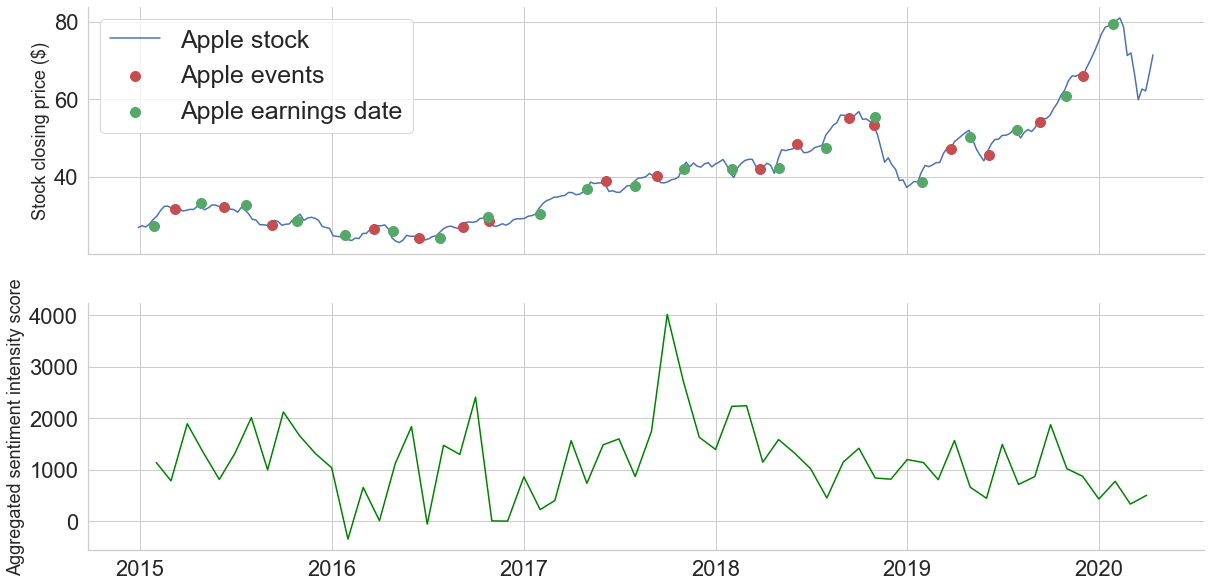

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,10))
ax1.plot(stock_data_weekly_average.Date, stock_data_weekly_average.Close, label='Apple stock')
ax1.set_ylabel('Stock closing price ($)', size=18)
ax1.scatter(apple_event_and_stock_data.Date, apple_event_and_stock_data.Close, c='r', s=100, zorder=3, label='Apple events')
ax1.scatter(apple_earnings_and_stock_data.Date, apple_earnings_and_stock_data.Close, c='g', s=100, zorder=3, label='Apple earnings date')
ax1.legend(prop={'size': 25})

ax2.plot(sentiment_monthly.Date, sentiment_monthly.Sentiment_score, color='green')
ax2.set_ylabel('Aggregated sentiment intensity score', fontsize=18)
plt.show();

 By just looking at the graphs, it is hard to tell if the sentiment and the stock price is related in any way. The `sentiment_monthly` use the first date of the next month to calculate sentiment, while `stock_diff_monthly` use the last day of this month used to calculate stock difference as seen below:

In [52]:
print("sentiment_monthly: " + str(sentiment_monthly.Date[0]) + ", stock_diff_monthly: " + str(stock_diff_monthly.index[0]))

sentiment_monthly: 2015-02-01 00:00:00, stock_diff_monthly: 2015-01-31 00:00:00


We substract one day from the `sentiment_monthly` such that we easily can merge the two dataframes together based on the `Date`-values.

In [53]:
sentiment_monthly['Date']=sentiment_monthly['Date']-DateOffset(days=1)

 We therefore tries to merge the two dataframes by the `Date`-column to further explore the relationships between the sentiment and price.

In [54]:
stock_price_sentiment_monthly = pd.merge(stock_diff_monthly, sentiment_monthly, how='inner', on = 'Date')

In [55]:
stock_price_sentiment_monthly.head()

,Date,Price_difference,Sentiment_score
0,2015-01-31,5.180002,1142.3663
1,2015-02-28,8.818300,788.0255
2,2015-03-31,-3.729207,1894.8802
3,2015-04-30,0.264381,1344.7904
4,2015-05-31,3.314830,815.1817


We then plot the development of the stock price and the development of the sentiment to see if we see any obvious relationships between the two.

In [78]:
sns.set_theme(style="whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False},
              font_scale=2)

Text(0, 0.5, 'Sentiment score for current motnh')

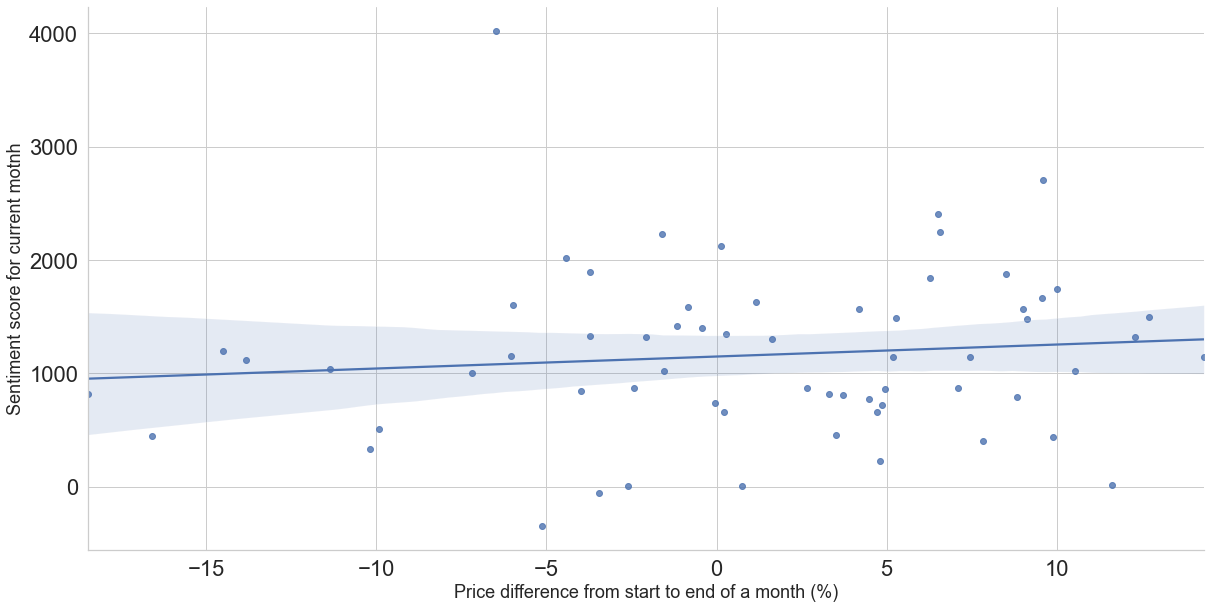

In [79]:
fig, ax=plt.subplots(figsize=(20,10))
ax=sns.regplot(x=stock_price_sentiment_monthly.Price_difference, y=stock_price_sentiment_monthly.Sentiment_score)
ax.set_xlabel('Price difference from start to end of a month (%)', size=18)
ax.set_ylabel('Sentiment score for current motnh', size=18)

We see a slightly positive relationship by looking at the correlation between the stock price and the sentiment score. From this, it might seem that it is more likely to rise in months where the Apple stock gets a lot of positive media attention. However, these findings are not very useful when predicting future stock prices because we would not know the sentiment before the end of the month.

In [58]:
t_statistic, t_pvalue = ttest_ind(stock_price_sentiment_monthly.Sentiment_score, stock_price_sentiment_monthly.Price_difference)
print(f"Between monthly sentiment and monthly price difference: T-statistic: {t_statistic} | p-value: {t_pvalue}")

Between monthly sentiment and monthly price difference: T-statistic: 12.534189512580664 | p-value: 8.714024269693822e-24


Our null-hypothesis is that there exists some relationship between the `Sentiment_score` and the `Price_difference`. However, with a p-value of $8.7 \times 10^{-24}<<0.05$, the t-test indicates that no such relationship exists.

### Stock price for current month and sentiment from previous month

We now want to see if there exists a correlation between the previous month sentiment score and this months stock price. This is because such a correlation might help us say something about the most likely future development of the stock.

In [59]:
sentiment_previous_month=sentiment_monthly.copy()

#Shifts the date one month back in time
sentiment_previous_month['Date']=sentiment_previous_month['Date']-DateOffset(months=1, days=5)+MonthEnd(1)

#Merge the stock_diff_monthly with the sentiment_previous_month. Each row represent the sentiment for previous month and the stock_price for this month
stock_sentiment_previous_month=pd.merge(stock_diff_monthly, sentiment_previous_month, how='inner', on = 'Date')

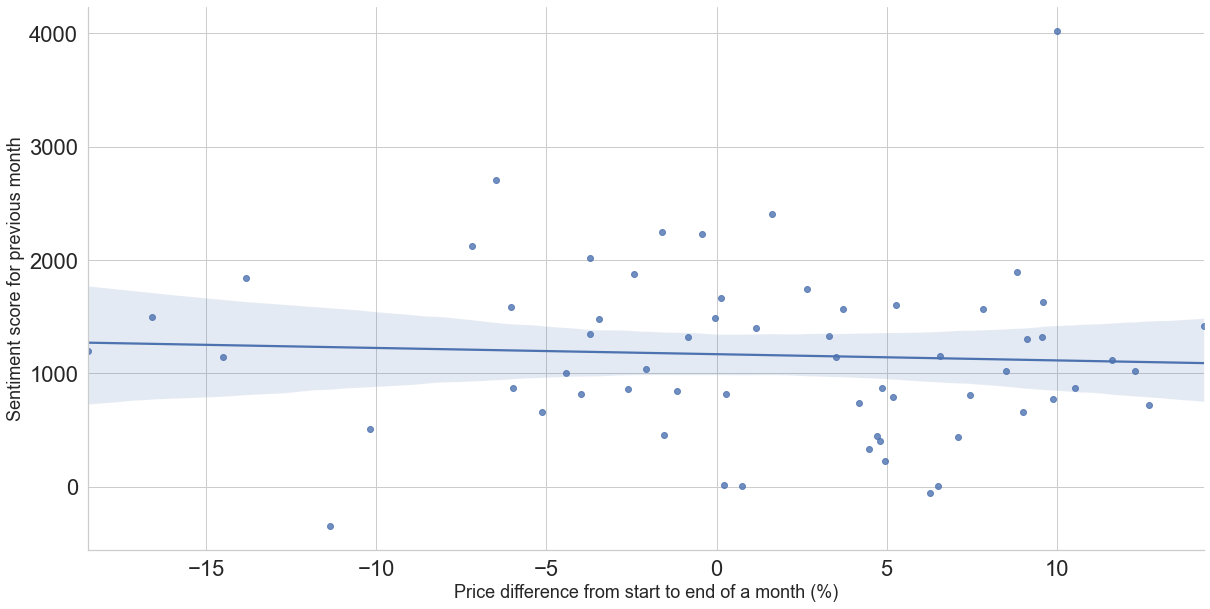

In [80]:
fig, ax=plt.subplots(figsize=(20,10))
sns.regplot(x=stock_sentiment_previous_month.Price_difference, y=stock_sentiment_previous_month.Sentiment_score)
ax.set_xlabel('Price difference from start to end of a month (%)', size=18)
ax.set_ylabel('Sentiment score for previous month', size=18);

From the graph it might seem to be a negative relationship between the sentiment for the previous month and the price for this month. Based on this we can expect that a stock is more likely to increase in price following a month where we have seen a low sentiment score and vice versa. We check how likely that this relationship exists using a t-test.

In [61]:
t_statistic, t_pvalue = ttest_ind(stock_sentiment_previous_month.Sentiment_score, stock_sentiment_previous_month.Price_difference)
print(f"Between monthly sentiment and monthly price difference: T-statistic: {t_statistic} | p-value: {t_pvalue}")

Between monthly sentiment and monthly price difference: T-statistic: 12.335136617277817 | p-value: 3.412600836144467e-23


The test also here shows no statistically significant relationship between the prices of this month and the sentiment score from last month. We are thus still without findings when looking for a correlation between the quotes and the stock price.

#### Boxplot of the findings

In [62]:
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference']<=-15, 'Category'] = 1
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference'].between(-15,-10), 'Category'] = 2
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference'].between(-10,-5), 'Category'] = 3
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference'].between(-5,0), 'Category'] = 4
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference'].between(0,5), 'Category'] = 5
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference'].between(5,10), 'Category'] = 6
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference'].between(10,15), 'Category'] = 7
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference']>=15, 'Category'] = 8

In [83]:
sns.set_theme(style="white", rc={"axes.spines.right": False, "axes.spines.top": False},
              font_scale=2)

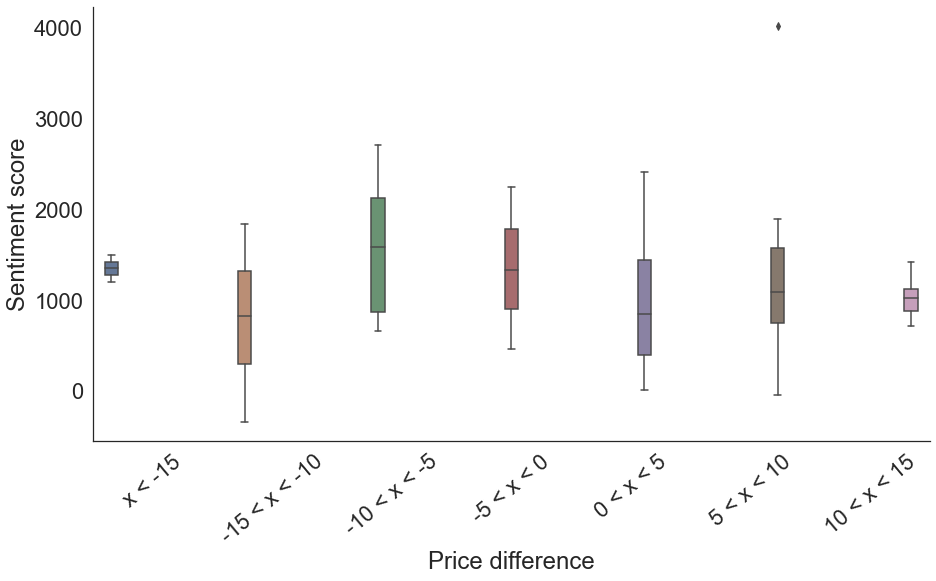

In [84]:
fig, ax = plt.subplots(figsize=(15,8))
plot=sns.boxplot(x='Category', y='Sentiment_score', data=stock_sentiment_previous_month, hue='Category', saturation=0.5)
plt.legend([],[], frameon=False)           
ax.set_ylabel('Sentiment score')
ax.set_xlabel('Price difference')
positions = (0, 1, 2, 3, 4, 5, 6,)
labels = ('x < -15', '-15 < x < -10', '-10 < x < -5', '-5 < x < 0', '0 < x < 5', '5 < x < 10', '10 < x < 15')
plt.xticks(positions, labels, rotation=40);

### Stock price for current month and sentiment for following month

Another interesting question to look into is if a stock rises more before it gets all the media i.e. that people just hear the good news when it is already to late to buy the stock. Therefore we want to see the correlation between the stock price and its sentiment score the following month.

In [64]:
sentiment_following_month=sentiment_monthly.copy()

In [65]:
#Shifts all dates to the following month
sentiment_following_month['Date']=sentiment_following_month['Date']+DateOffset(days=5)+MonthEnd(1)

In [66]:
stock_sentiment_following_month=pd.merge(stock_diff_monthly, sentiment_following_month, how='inner', on = 'Date')

In [85]:
sns.set_theme(style="whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False},
              font_scale=2)

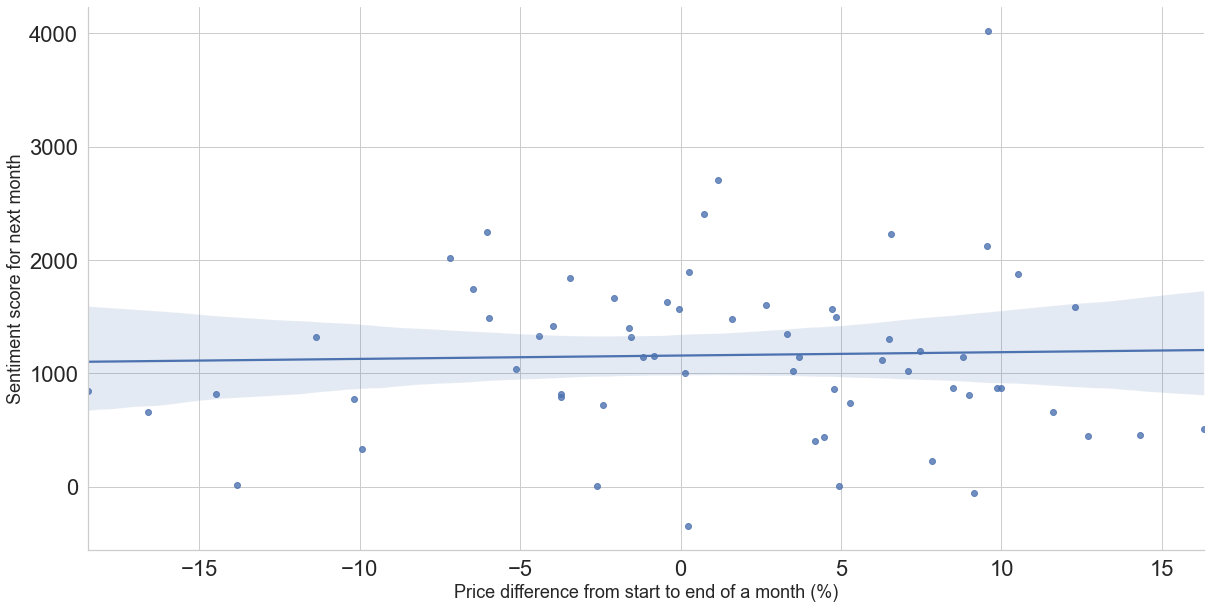

In [86]:
fig, ax=plt.subplots(figsize=(20,10))
ax=sns.regplot(x=stock_sentiment_following_month.Price_difference, y=stock_sentiment_following_month.Sentiment_score)
ax.set_xlabel('Price difference from start to end of a month (%)', size=18)
ax.set_ylabel('Sentiment score for next month', size=18);

In [68]:
t_statistic, t_pvalue = ttest_ind(stock_sentiment_following_month.Sentiment_score, stock_sentiment_following_month.Price_difference)
print(f"Between monthly sentiment and monthly price difference: T-statistic: {t_statistic} | p-value: {t_pvalue}")

Between monthly sentiment and monthly price difference: T-statistic: 12.532243077884946 | p-value: 8.808897640476296e-24


Here as well, we see no relationship between price and sentiment score.

## Correlation between stock and sentiment (weeks)

So far, we have no results of interest. Therefore, we want to narrow the periods to see if they give any better results than above.

### Stock price and sentiment for current week

In [69]:
stock_sentiment_weekly = pd.merge(stock_diff_weekly, sentiment_weekly, how='inner', on = 'Date')

In [70]:
t_statistic, t_pvalue = ttest_ind(stock_sentiment_weekly.Sentiment_score, stock_sentiment_weekly.Price_difference)
print(f"Between monthly sentiment and monthly price difference: T-statistic: {t_statistic} | p-value: {t_pvalue}")

Between monthly sentiment and monthly price difference: T-statistic: 14.724704769113758 | p-value: 3.468877779870166e-39


### Stock price for current week and sentiment from previous week

In [71]:
sentiment_previous_week=sentiment_weekly.copy()

#Shifts the date one week back in time
sentiment_previous_week['Date']=sentiment_previous_week['Date']-DateOffset(days=7)

#Merge the sentiment_previous_week with the stock_diff_weekly. Each row represent the sentiment for previous month and the stock_price for this month
stock_sentiment_previous_week=pd.merge(stock_diff_weekly, sentiment_previous_week, how='inner', on = 'Date')

In [72]:
t_statistic, t_pvalue = ttest_ind(stock_sentiment_previous_week.Sentiment_score, stock_sentiment_previous_week.Price_difference)
print(f"Between monthly sentiment and monthly price difference: T-statistic: {t_statistic} | p-value: {t_pvalue}")

Between monthly sentiment and monthly price difference: T-statistic: 14.727679902989891 | p-value: 3.37284675461044e-39


### Stock price for current week and sentiment for following week

In [73]:
sentiment_following_week=sentiment_weekly.copy()

#Shifts the date one week back in time
sentiment_following_week['Date']=sentiment_following_week['Date']+DateOffset(days=7)

#Merge the sentiment_previous_week with the stock_diff_weekly. Each row represent the sentiment for previous month and the stock_price for this month
stock_sentiment_following_week=pd.merge(stock_diff_weekly, sentiment_following_week, how='inner', on = 'Date')

In [74]:
t_statistic, t_pvalue = ttest_ind(stock_sentiment_following_week.Sentiment_score, stock_sentiment_following_week.Price_difference)
print(f"Between monthly sentiment and monthly price difference: T-statistic: {t_statistic} | p-value: {t_pvalue}")

Between monthly sentiment and monthly price difference: T-statistic: 14.724219790942795 | p-value: 3.484788493299705e-39


## Conclusion

After looking at the weekly and the monthly values of the price change and the sentiment score, we found no statistically significant correlation. In general, we can therefore not say if there exists any relationship between the two.